# Radon

Posterior DB model taken from [here](https://github.com/stan-dev/posteriordb/blob/master/posterior_database/models/stan/radon_hierarchical_intercept_noncentered.stan).
\begin{align*}
\log(y) & \sim\mathcal{N}\left(\alpha_{j\left(i\right)}+\beta_{1}\mathtt{upper}_{j}+\beta_{2}\mathtt{floor}_{i},\sigma_{y}^{2}\right),\quad i=1,\dots,N\\
\alpha_{j\left(i\right)} & \sim\mathcal{N}\left(\mu_{\alpha},\sigma_{\alpha}^{2}\right),\quad j=1,\dots,J\\
\mu_{\alpha} & \sim\mathcal{N}\left(0,10\right)\\
\beta_{k} & \sim\mathcal{N}\left(0,10\right),\quad k=1,2\\
\sigma_{y} & \sim\mathcal{N}_{+}\left(0,1\right)\\
\sigma_{\alpha} & \sim\mathcal{N}_{+}\left(0,1\right)
\end{align*}

In [2]:
from pcv.models import radon
from pcv.inference import run_cv_sel
from pcv.rules import make_positive_rule, make_positive_negative_rule
from pcv.plots import plot_model_results, plot_fold_results
import jax
import jax.numpy as jnp

In [3]:
data = radon.get_data()
make_initial_pos, log_pred, logjoint_density = radon.get_model(data)
J = int(data['J'])

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [4]:
results = run_cv_sel(
    prng_key=jax.random.PRNGKey(0),
    logjoint_density=logjoint_density,
    log_p=log_pred,
    make_initial_pos=make_initial_pos,
    stoprule=make_positive_rule(num_folds=J, level=0.95),
    num_folds=J,
    num_chains=4,
    batch_size=100,
    warmup_iter=5000,
    max_batches=15,
    ignore_stoprule=True
)

MEADS warmup for 386 folds per model (3088 chains)...


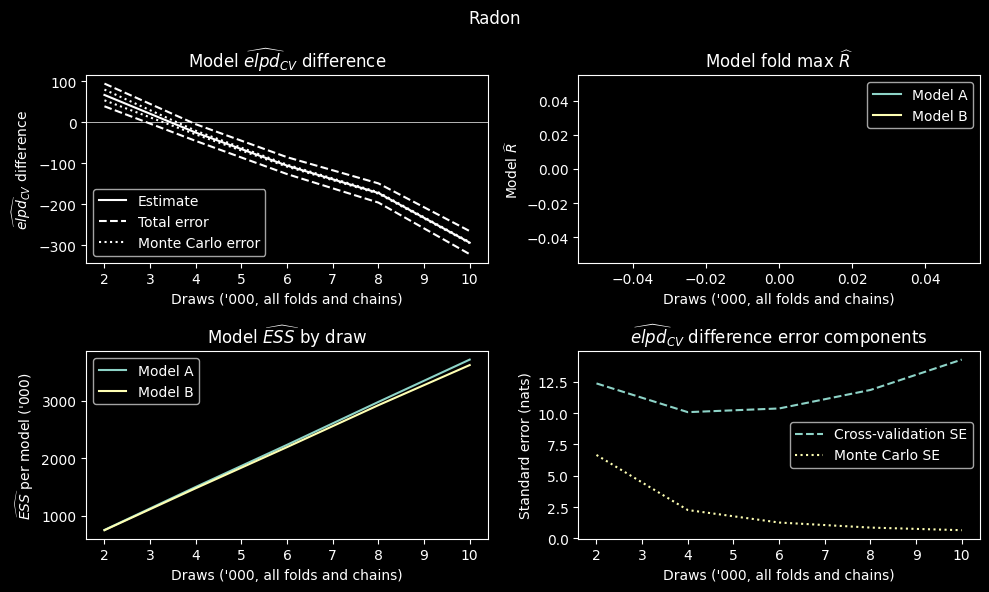

In [ ]:
plot_model_results(results, title="Radon")

/home/acooper/src/papers/parallel/code/pcv/plots.py:112: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


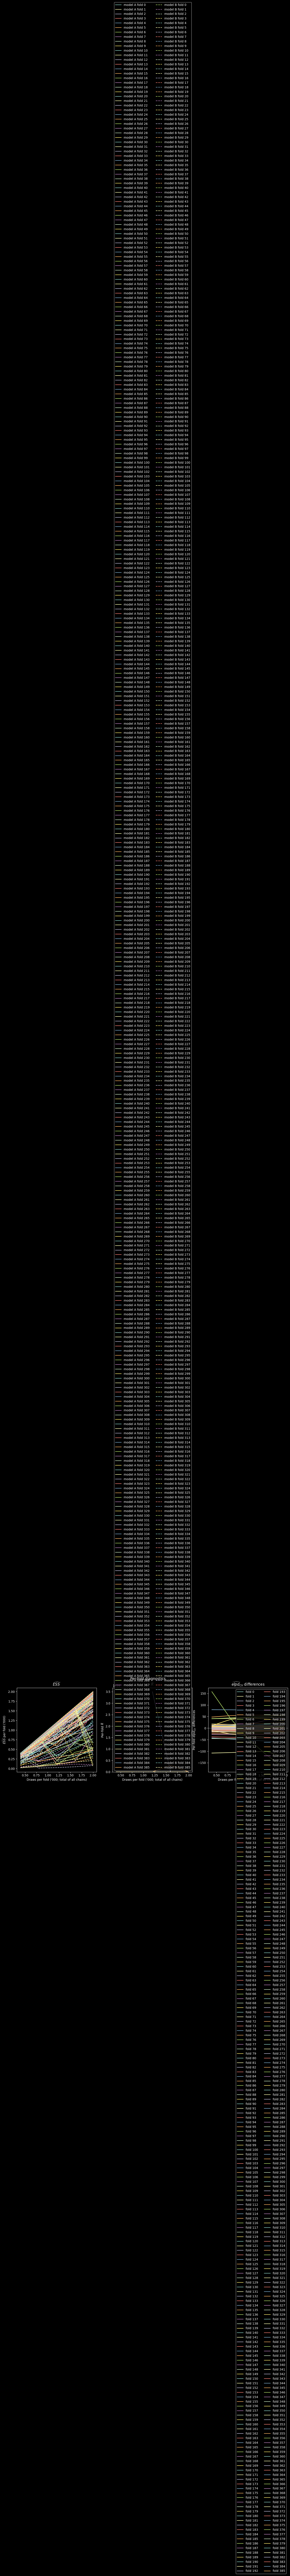

In [ ]:
plot_fold_results(results, title='Per-fold diagnostics', show_legend=False)